In [417]:
import os
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

tf.InteractiveSession()

model = "models/orig/karras2018iclr-lsun-cat-256x256.pkl"

print("open model %s" % model)
with open(model, 'rb') as file:
    G, D, Gs = pickle.load(file)

faves=[]

def bookmark(latents, new_faves):
    for f in new_faves:
        faves.append(latents[f])

def show_faves(faves):
    latents = np.array(faves)
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    n = len(faves)
    nr, nc = int(n / 6), 6
    for r in range(nr):
        images = Gs.run(latents[6*r:min(n-1, 6*(r+1))], labels[6*r:min(n-1, 6*(r+1))])
        images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
        images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
        img1 = np.concatenate([img for img in images], axis=1)
        plt.figure(figsize=(24,4))
        plt.imshow(img1)
        
def random_sample(num_images):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, labels)
    images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
    images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(24,4))
    plt.imshow(images_ct)
    return images, latents

def get_latent_interpolation(endpoints, num_frames_per, mode, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    num_endpoints, dim = len(endpoints), len(endpoints[0])
    num_frames = num_frames_per * num_endpoints
    endpoints = np.array(endpoints)
    latents = np.zeros((num_frames, dim))
    for e in range(num_endpoints):
        e1, e2 = e, (e+1)%num_endpoints
        for t in range(num_frames_per):
            frame = e * num_frames_per + t
            r = 0.5 - 0.5 * np.cos(np.pi*t/(num_frames_per-1)) if mode == 'ease' else float(t) / num_frames_per
            latents[frame, :] = (1.0-r) * endpoints[e1,:] + r * endpoints[e2,:]
    return latents

def generate_images(latents, labels):
    batch_size = 8
    num_frames = latents.shape[0]
    num_batches = int(np.ceil(num_frames/batch_size))
    images = []
    for b in tqdm(range(num_batches)):
        new_images = Gs.run(latents[b*batch_size:min((b+1)*batch_size, num_frames-1), :], labels[b*batch_size:min((b+1)*batch_size, num_frames-1),:])
        new_images = np.clip(np.rint((new_images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
        new_images = new_images.transpose(0, 2, 3, 1) # NCHW => NHWC
        for img in new_images:
            images.append(img)
    return images

def make_movie(images, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    for idx in tqdm(range(len(images))):
        PIL.Image.fromarray(images[idx], 'RGB').save('%s/frame%05d.png' % (temp_dir, idx))
    cmd = 'ffmpeg -i %s/frame%%05d.png -c:v libx264 -pix_fmt yuv420p %s/%s.mp4' % (temp_dir, out_dir, out_name)
    print(cmd)
    os.system(cmd)
    os.system('rm -rf %s'%temp_dir)

/home/gene/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


open model models/orig/karras2018iclr-lsun-cat-256x256.pkl


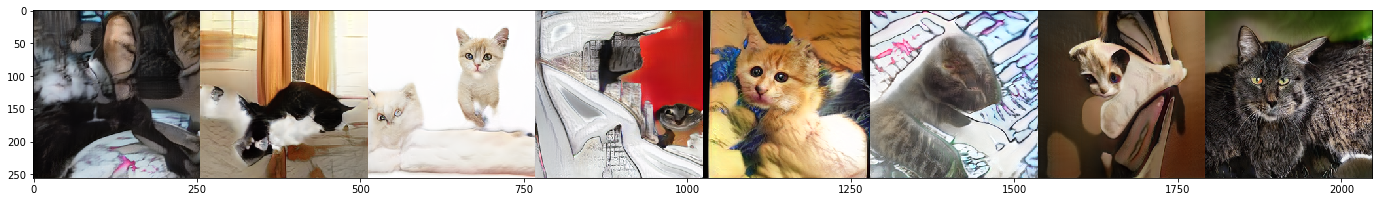

In [424]:
images, latents = random_sample(8)

In [425]:
bookmark(latents, [2, 4, 5, 7])

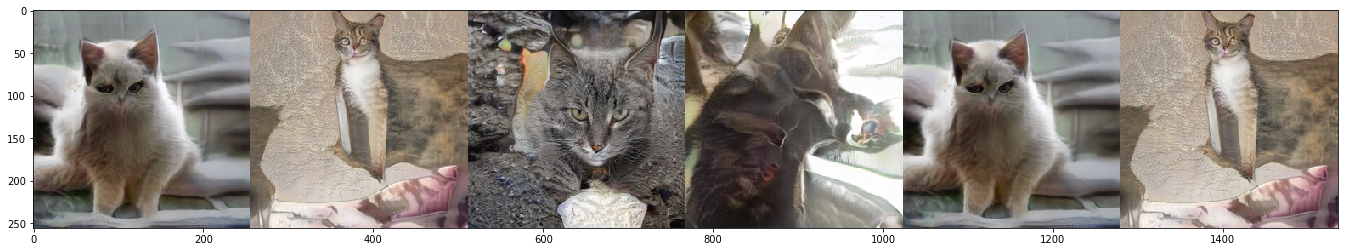

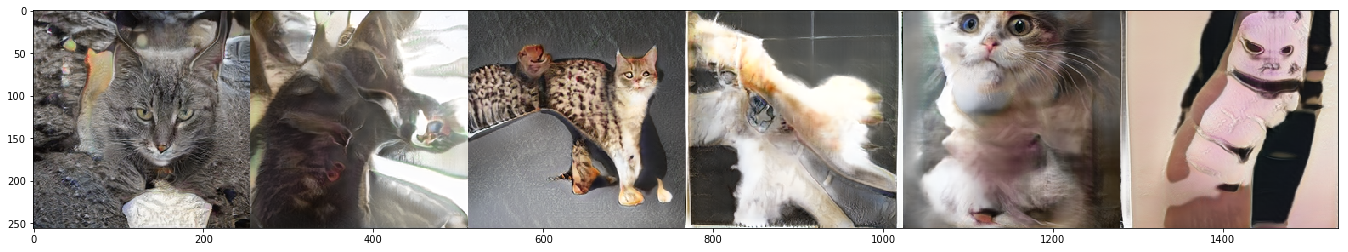

In [426]:
show_faves(faves)

In [439]:
latents = get_latent_interpolation(faves, 10, 'linear', True)
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
images = generate_images(latents, labels)    
make_movie(images, '.', 'mytemp')

100%|██████████| 159/159 [00:03<00:00, 41.86it/s]


ffmpeg -i frames613395/frame%05d.png -c:v libx264 -pix_fmt yuv420p ./mytemp.mp4.mp4
